In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
class MLP(tf.Module):
    """
    Multi-Layer Perceptron (MLP) class with regularization handling.

    --------------
    insize: input size (int)
    outsize: output size (int)
    hsize: A list specifying the number of neurons in each hidden layer (list of ints).
    bias: Boolean indicating whether to include a bias term in the linear layers (default: True)
    nonlin: The activation function to be used in the hidden layers (default: nn.Tanh).
    linear_map:  The type of linear transformation to be used (default: nn.Linear)
    """
    def __init__(self, insize, outsize, hsizes, bias=True, nonlin=tf.tanh, linear_map=tf.keras.layers.Dense):
        super().__init__()
        self.in_features, self.out_features = insize, outsize
        self.nhidden = len(hsizes)
        self.layers = []
        self.nonlin = []
        self.seed = 123
        # Create linear layers and activation functions
        layer_sizes = [insize] + hsizes + [outsize]
        for k in range(len(layer_sizes) - 1):
            initializer = tf.keras.initializers.GlorotUniform(self.seed+k)
            self.layers.append(linear_map(units=layer_sizes[k+1], use_bias=bias, kernel_initializer=initializer))
            if k < self.nhidden:
                self.nonlin.append(nonlin)
            else:
                self.nonlin.append(tf.identity)

    def __call__(self, x):
        for i in range(len(self.layers)):
            x = self.nonlin[i](self.layers[i](x))
        return x

    def reg_error(self):
        """
        Compute the regularization error for the linear layers that support it.
        """
        reg_loss = 0.0
        for layer in self.layers:
            if hasattr(layer, "reg_error"):
                reg_loss += layer.reg_error()
        return reg_loss


In [ ]:
class ResNetBlock(tf.Module):
    """
    A single ResNet block that takes the current output (from the previous layer or from the single-fidelity model)
    and the original input x, and learns a residual mapping.

    The block computes:
    out_new = out_old + alpha * F(x)

    F is implemented by an MLP.
    """
    def __init__(self, in_dim_x, in_dim_out, hres_sizes=[20, 20], bias=True, nonlin=tf.tanh):
        """
        in_dim_x : int, dimension of input x
        in_dim_out : int, dimension of the output (u)
        hres_sizes : list of ints, hidden layer sizes for the residual MLP
        bias : bool, whether to include bias in MLP layers
        nonlin : activation function class (e.g., nn.Tanh)
        """
        super().__init__()
        self.res_mlp = MLP(in_dim_x, in_dim_out, hsizes=hres_sizes, bias=bias, nonlin=nonlin)

    def __call__(self, x, out_old, alpha):
        """
        Forward pass of the ResNet block.

        x: tensor of shape (N, in_dim_x)
        out_old: tensor of shape (N, in_dim_out)
        alpha: scalar parameter controlling the amplitude of the residual update.

        return: out_new = out_old + alpha * F(x)
        """
        residual = self.res_mlp(x)
        out_new = out_old + tf.abs(alpha) * residual
        return out_new

# Define the Stacked MLP class for Stacked PINN with ResNet blocks
class StackedMLP(tf.Module):
    """
    Stacked Multi-Layer Perceptron designed for multi-fidelity learning where multiple layers are
    stacked to refine the prediction progressively. Now, each stacked layer is a ResNet block.
    """
    def __init__(
        self,
        insize,
        outsize,
        h_sf_sizes=[20, 20], # The single fidelity hidden size
        n_stacked_mf_layers=3,
        # The residual block hidden sizes for each stacked layer
        h_res_sizes=[20,20,20],
        bias=True,
        nonlin=tf.tanh,
        alpha_init=0.1,
        u_initial=None
    ):
        super().__init__()
        self.insize = insize
        self.outsize = outsize
        self.h_sf_sizes = h_sf_sizes
        self.n_stacked_mf_layers = n_stacked_mf_layers
        self.h_res_sizes = h_res_sizes
        self.bias = bias
        self.nonlin = nonlin
        self.alpha_init = alpha_init
        
        if u_initial is None:
            self.u0 = tf.zeros(shape=(outsize, 1), dtype=tf.float32)
        else:
            self.u0 = u_initial

        # Initial single-fidelity MLP
        self.first_layer = MLP(insize, outsize, hsizes=h_sf_sizes, bias=bias, nonlin=nonlin)

        # Alpha parameters, one per stacked layer
        self.alpha = [tf.Variable(0.0, trainable=True)] + [tf.Variable(alpha_init, trainable=True) for _ in range(n_stacked_mf_layers)]

        # Considering each stacked layer as a ResNet block
        self.layers = []
        for _ in range(n_stacked_mf_layers):
            res_block = ResNetBlock(insize, outsize, hres_sizes=self.h_res_sizes, bias=bias, nonlin=nonlin)
            self.layers.append(res_block)

    def __call__(self, x, i=None):
        if i is None:
            i = self.n_stacked_mf_layers
        i = min(i, self.n_stacked_mf_layers)

        # First layer (single-fidelity MLP)
        out = self.first_layer(x)
        out_old = tf.zeros_like(out)
        residual = out
        
        # Apply stacked ResNet blocks up to layer i
        for j in range(i):
            alpha = self.alpha[j+1]
            layer = self.layers[j]
            # Each layer: out = out + alpha * res_mlp(x)
            out_old = out
            out = layer(x, out_old, alpha)
            residual = out - out_old
        #return out_new, out_old, and residual
        return self.u0 + tf.tanh(x) * out, self.u0 + tf.tanh(x) * out_old, tf.tanh(x) * residual

    def get_alpha_loss(self, i=None):
        """
        Retrieve the accumulated loss from alpha parameters used for regularization purposes.

        :return: Alpha loss as a torch scalar.
        """
        return tf.pow(self.alpha[i], 4)

# Numerical solution for the Van Der Pol Oscillator
def analytical_solution(n_steps, mu=3.0, T_max=2.0, u_0=[1.0, 0.0]):
    """
    Numerical solution of the Van der Pol oscillator using the RK4 method.

    Arguments:
    - n_steps: number of time steps
    - mu     : nonlinearity/damping parameter of the Van der Pol equation
    - T_max  : final time
    - u_0    : initial state [x1(0), x2(0)], where:
            x1 = position
            x2 = velocity

    Returns:
    - x: trajectory (n_steps, 2), position and velocity over time
    - t: time array (n_steps,)
    """
    dt = T_max / float(n_steps)
    t = np.arange(0, n_steps * dt, dt)
    x = np.zeros((n_steps, 2))
    x[0, :] = u_0
    
    def vdp(t, x):
        x1, x2 = x
        dx1 = x2
        dx2 = mu * (1 - x1**2) * x2 - x1
        return np.array([dx1, dx2])
    
    for i in range(n_steps - 1):
        k1 = vdp(t[i], x[i])
        k2 = vdp(t[i] + dt/2, x[i] + dt/2 * k1)
        k3 = vdp(t[i] + dt/2, x[i] + dt/2 * k2)
        k4 = vdp(t[i] + dt, x[i] + dt * k3)
        x[i+1] = x[i] + dt/6 * (k1 + 2*k2 + 2*k3 + k4)

    return tf.convert_to_tensor(x, dtype=tf.float32), tf.convert_to_tensor(t, dtype=tf.float32)

# Define the L2 relative error function
def l2_relative_error(u_pred, u_true):
    """
    Compute L2 relative error between predicted values and true values.

    Parameters:
    u_pred (Tensor): Predicted values (model output)
    u_true (Tensor): True values (ground truth)

    Returns:
    float: L2 relative error
    """
    error = tf.norm(u_pred - u_true, ord=2) / tf.norm(u_true, ord=2)
    return error.numpy().item()

# Define the Stacked PINN class with modifications to store losses
class StackedResPINN:
    def __init__(self, model, optimizer_primal, optimizer_dual, lr_scheduler=None, patience=100, patience_gamma=1000, N_collocation=1000, N_resample=50, N_dual=10, gammas_init=[], parameters_init=3.0, logger=None, T_max=2.0):
        self.model = model
        self.optimizer_primal = optimizer_primal
        self.optimizer_dual = optimizer_dual
        self.lr_scheduler = lr_scheduler
        self.logger = logger
        self.n_stacked_layers = model.n_stacked_mf_layers+1  # Number of stacked layers (Using for averaging loss) +1 for vanilla layer 0
        self.N_phys = N_collocation
        self.N_resample = N_resample
        self.N_dual = N_dual
        # Early stopping attributes
        self.patience = patience
        self.patience_gamma = patience_gamma
        self.best_loss = 0.0
        self.bad_epochs = 0
        self.bad_epochs_gamma = 0

        self.T_max = T_max
        self.weight = tf.Variable(1.0, dtype=tf.float32)
        self.parameters = parameters_init
        self.mu = self.parameters

        self.epsilon = tf.Variable(1.0e-2, dtype=tf.float32, trainable=False)
        self.omegas_t = tf.Variable(tf.zeros((self.n_stacked_layers, N_collocation), dtype=tf.float32), trainable=False)

        self.K = 0  # K is the index of the stack being updated
        self.update_count = 1

        # initialize the sequence alpha and the sitffness sigma of each stack
        self.gammas = tf.Variable(initial_value=gammas_init, trainable=False)
        self.old_gammas = self.gammas # for early stopping check
        self.sigma = tf.Variable(initial_value= (-1.0e-3) * tf.ones([self.n_stacked_layers], dtype=tf.float32),trainable=False)

    def resample(self):
        t_collocation = tf.random.uniform(shape=(self.N_phys, 1), minval=0, maxval=self.T_max)
        return t_collocation


    #############################       UPDATE ALPHA        ############################

    def cummin(self, x):
        """ 
        function cummin to force the sequence gamma_i to be nondecreasing:
            - takes a sequence a_i as entry
            - returns a sequence where each term gamma_i = min(gamma_i, gamma_i+1) begining with the first term
        """
        x = tf.convert_to_tensor(x)
        x_list = tf.unstack(x)

        out = []
        current_min = x_list[0]
        out.append(current_min)

        for xi in x_list[1:]:
            current_min = tf.minimum(current_min, xi)
            out.append(current_min)

        return tf.stack(out)
    
    def update_stiffness_indicators(self, t):
        """
        compute the stiffness indicator of each stack at each time t* = = argmin(sigma_N(t))
        """
        # compute the current solution of each stack
        u1 = []
        for k in range(self.n_stacked_layers):
            U, _, _ = self.model(t, i=k)
            u1.append(U[:, 0:1])
        u1 = tf.squeeze(tf.stack(u1, axis=1), axis=2)

        #compute sigma
        sigma = self.mu * (1.0 - u1**2) / 2.0

        # get t* = argmin(sigma_N(t)) and get each sigma_i at t*
        last_layer_sigma = sigma[:, -1]
        min_index = tf.argmin(last_layer_sigma)
        sigma_at_min_index = sigma[min_index, :]
        self.sigma.assign(self.cummin(sigma_at_min_index))

    def update_gammas(self, smoothing_coef, t):
        """
        updates the sequence gamma_i depending on the stiffness gamma_i of the solution of each stack:
            - gamma_i = (i+1)/(N+1) * sigma_N(t*)/sigma_i(t*)
            - t* = argmin(sigma_N(t))
        """
        self.update_stiffness_indicators(t)
        i_s = tf.cumsum(tf.ones([self.n_stacked_layers], dtype=tf.float32))

        # compute each new gamma_i
        alpha_i = tf.abs((i_s*self.sigma[-1]) / (self.n_stacked_layers*self.sigma))

        new_gammas = tf.minimum(alpha_i, tf.ones([self.n_stacked_layers], dtype=tf.float32))   # force gamma_i to range between 0 and 1
        new_gammas = tf.reverse(self.cummin(tf.reverse(new_gammas, axis=[0])), axis=[0]) # prevent each gamma_i to be higher than gamma_(i+1)
        new_gammas = tf.stop_gradient((1 - smoothing_coef) * self.gammas + smoothing_coef * new_gammas) # smooth gamma and prevent gradient propagation through its computation
        self.gammas.assign(new_gammas)


    #############################       LOSS       ############################

    def f(self, u1, u2, alpha):
        term1 = u2
        term2 = alpha * self.mu * (1 - tf.square(u1)) * u2 - u1
        return [term1, term2]

    @tf.function
    def loss_function(self, t, k):
        """
        loss function to compute the residual loss of stack k
            - k is the index of the stack currently being optimized
        """
        losses = []
        omegas_t = []
        inp = t

        for i in range(self.n_stacked_layers):
            if i == k:  # if i is the index of the stack currently being optimized
                if i ==0:
                    with tf.GradientTape(watch_accessed_variables=False) as tape1:
                        tape1.watch(inp)
                        U, _, _ = self.model(inp, i=i)
                    U_t = tape1.batch_jacobian(U, inp)
                    u1 = U[:, 0:1]
                    u2 = U[:, 1:2]
                    
                    f = tf.squeeze(U_t, axis=2) - tf.concat(self.f(u1, u2, self.gammas[i]), axis=1)

                else:
                    with tf.GradientTape(watch_accessed_variables=False) as tape1:
                        tape1.watch(inp)
                        U, U_old, R = self.model(inp, i=i)
                    R_t = tape1.batch_jacobian(R, inp)
                    u1 = U[:, 0:1]
                    u2 = U[:, 1:2]
                    u1_old = U_old[:, 0:1]
                    u2_old = U_old[:, 1:2]
                    
                    f = tf.squeeze(R_t, axis=2) - tf.concat(self.f(u1, u2, self.gammas[i]), axis=1) + tf.concat(self.f(u1_old, u2_old, self.gammas[i-1]), axis=1)
                
                f_squared = tf.square(f)
                f_squared_sum = tf.reduce_sum(f_squared, axis=1, keepdims=True)
                f_squared_cumsum = tf.cumsum(f_squared_sum, exclusive=True)
                omega_t = tf.stop_gradient(tf.exp(-self.epsilon * f_squared_cumsum))
                weighted_f_squared = omega_t * f_squared
                
                ode_i = self.weight * tf.reduce_mean(weighted_f_squared) + self.model.get_alpha_loss(i=i)
                
            else:   # if i is NOT the index of the stack currently being optimized, do not comput loss at this stack
                ode_i = 0.0
                u1 = tf.zeros_like(inp[:, :1])
                if i < k:
                    omega_t = tf.stop_gradient(tf.ones((self.N_phys, 1), dtype=tf.float32))
                else:
                    omega_t = tf.stop_gradient(tf.zeros((self.N_phys, 1), dtype=tf.float32))

            omegas_t.append(omega_t)
            losses.append(ode_i)

        self.omegas_t.assign(tf.squeeze(tf.stack(omegas_t, axis=0), axis=-1))

        return losses
    
    def get_target_variables(self, k):
        """
        get weights and biaises theta of stack k to be optimized
        """
        variables = []
        if k == 0:
            variables.extend(self.model.first_layer.trainable_variables)
        else:
            variables.extend(self.model.layers[k-1].trainable_variables)
        variables.append(self.model.alpha[k])
        return variables

    @tf.function
    def total_loss(self, t_collocation, k):
        physics_loss = self.loss_function(t_collocation, k)
        return sum(physics_loss)

    @tf.function
    def primal_update_k(self, t_collocation, target_variables, k):
        with tf.GradientTape(watch_accessed_variables=False) as loss_tape:
            loss_tape.watch(target_variables)
            loss = self.total_loss(t_collocation, k)
        grads = loss_tape.gradient(loss, target_variables)
        self.optimizer_primal[k].apply_gradients(zip(grads, target_variables))
        return loss
    
    def primal_update(self, t_collocation):
        target_variables = self.get_target_variables(self.K)
        loss = self.primal_update_k(t_collocation, target_variables, self.K)
        return loss
    
    @tf.function
    def dual_update(self, t_collocation):
        with tf.GradientTape(watch_accessed_variables=False) as loss_tape:
            loss_tape.watch(self.weight)
            loss = -self.loss_function(t_collocation, self.K)[self.K]
        grads = loss_tape.gradient(loss, [self.weight])
        self.optimizer_dual.apply_gradients(
            zip(grads, [self.weight])
        )
        return -loss


    #############################       TRAIN       ############################

    def train(self, t_collocation, n_stacked_mf_layers, epochs=1000, t_test=None, u_test=None, u_0=[1.0, 0.0]):
        
        """
        initialize the N+1 optimizers
        """
        all_trainable_vars = []
        for j in range(self.n_stacked_layers):
            _ = self.model(t_collocation, i=j)
            _ = self.model.get_alpha_loss(i=j)
            if j > 0:
                all_trainable_vars.extend(self.model.layers[j-1].trainable_variables)
            else:
                all_trainable_vars.extend(self.model.first_layer.trainable_variables)
            all_trainable_vars.append(self.model.alpha[j])

            with tf.GradientTape() as tape:
                dummy_loss = self.total_loss(t_collocation, j)
            dummy_grads = tape.gradient(dummy_loss, all_trainable_vars)
            grads_and_vars = [(g, v) for g, v in zip(dummy_grads, all_trainable_vars) if g is not None]
            self.optimizer_primal[j].apply_gradients(grads_and_vars)

        train_losses, test_losses, l2_errors, gammas, sigma, layer_updated, omegas_t, lambda_phys = ([] for _ in range(8))

        for epoch in range(epochs):

            loss = self.primal_update(t_collocation)
            if epoch % self.N_dual == 0 and epoch > 0: #dual update
                loss = self.dual_update(t_collocation)
            if epoch % self.N_resample == 0 and epoch > 0: #resampling of t_collocation
                t_collocation = self.resample()

            # Learning rate scheduling if type ReduceLROnPlateau
            if self.lr_scheduler:
                if hasattr(self.lr_scheduler, 'on_epoch_end'):
                    self.lr_scheduler.on_epoch_end(epoch=None, logs={"loss": loss.numpy()})
        
            # Logging
            if self.logger:
                self.logger.log_metrics({"loss": loss.numpy()}, step=epoch)

            # passing to next stack check
            if tf.reduce_mean(self.omegas_t[self.K]).numpy() > self.best_loss:
                self.best_loss = tf.reduce_mean(self.omegas_t[self.K]).numpy()
                self.bad_epochs = 0
            else:
                self.bad_epochs += 1

            if (self.bad_epochs >= self.patience and self.omegas_t[self.K][-1] > 0.9) or self.bad_epochs >= 2000:
                self.best_loss = 0.0
                print(f"self.omegas_t[self.K][-1] : {self.omegas_t[self.K][-1]}, loss.numpy() : {loss.numpy()}")
                if self.K < self.n_stacked_layers-1 and self.bad_epochs < 1000:
                    print(f"stack {self.K} has converged, passing to the next stack")
                    self.K += 1
                    self.bad_epochs = 0
                else:
                    print("all stacks converged, returning to stack 0")
                    if self.epsilon <= 1.0e-1:
                        self.epsilon.assign(self.epsilon * 10.0)
                    self.K = 0
                    self.bad_epochs = 0
                    self.update_count += 1
                    
                    # update u_test to visualize convergence with new gammas
                    n_steps = int(5e3)
                    u_test = []
                    for i in range(n_stacked_mf_layers+1):
                        u_t, _ = analytical_solution(n_steps, mu=self.mu * self.gammas[i], T_max=self.T_max, u_0=u_0)
                        u_test.append(u_t)

                    # early stopping check
                    if tf.reduce_mean(tf.square(self.gammas - self.old_gammas)) > 1.0e-2:
                        self.old_gammas = self.gammas
                        self.bad_epochs_gamma = 0
                    else:
                        self.bad_epochs_gamma += 1

                    if self.bad_epochs_gamma >= self.patience_gamma:
                        print(f"Early stopping triggered")
                        break                
             
            train_losses.append(loss.numpy())
            gammas.append(self.gammas.numpy().copy())
            sigma.append(self.sigma.numpy().copy())
            layer_updated.append(self.K)
            omegas_t.append(self.omegas_t.numpy().copy())
            lambda_phys.append(self.weight.numpy().copy())

            if epoch % 100 == 0 or epoch == epochs-1:
                # Calculate test loss if test data is provided
                if t_test is not None and u_test is not None:

                    u_pred_test = []
                    for i in range(self.model.n_stacked_mf_layers+1):
                        u_i, _, _ = self.model(t_test, i)
                        u_pred_test.append(u_i)
                    test_loss = [tf.reduce_mean(tf.square(u_pred_test_i - u_test_i)).numpy() for u_pred_test_i, u_test_i  in zip(u_pred_test, u_test)]
                    test_losses.append(test_loss)

                    # Compute L2 relative error
                    l2_error = [l2_relative_error(u_pred_test_i, u_test_i) for u_pred_test_i, u_test_i in zip(u_pred_test, u_test)]
                    l2_errors.append(l2_error)

                print(f"Epoch {epoch}, Loss: {loss.numpy():.4e}, L2 Relative_error: {[f'{err:.4f}' for err in l2_error]}, self.gammas: {[f'{gamma:.4f}' for gamma in self.gammas.numpy()]}, epsilon : {self.epsilon.numpy():.1e}, lambda_phys : {self.weight.numpy():.4f}, layer {self.K} is being updated for the {self.update_count}-th time")

        # Plot losses
        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label="Training Loss")
        if test_losses:
            # test_losses is a list of lists, one per epoch. Plotting the mean test loss across layers.
            mean_test_losses = [np.mean(tl) for tl in test_losses]
            plt.plot(mean_test_losses, label="Test Loss", color="orange")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title("Training and Test Loss")
        plt.legend()
        plt.grid(True)
        plt.savefig("losses over epochs.eps", format='eps')
        plt.show()

         # Plot L2 relative error over epochs
        if l2_errors:  # Check if l2_errors is not empty
            plt.figure()
            plt.plot(range(len(l2_errors)), l2_errors, label=[f"L2 Relative Error{i}" for i in range (n_stacked_mf_layers+1)])
            plt.xlabel("Epochs")
            plt.ylabel("L2 Relative Error")
            plt.title("L2 Relative Error over Training Epochs")
            plt.yscale("log")
            plt.legend()
            plt.grid(True)
            plt.savefig("L2 relative error over epochs.eps", format='eps')
            plt.show()

        # plot final output vs analytical solution
        t_test = tf.reshape(t_test, [-1]).numpy()
        sorted_indices = np.argsort(t_test)
        t_sorted = t_test[sorted_indices]
        
        u_pred_np = u_pred_test[-1].numpy()
        u_sorted = u_pred_np[sorted_indices]
        u_true_np = u_test[-1].numpy()
        u_true_sorted = u_true_np[sorted_indices]

        plt.figure(figsize=(10, 4))
        plt.subplot(3, 1, 1)
        plt.plot(t_sorted, u_sorted[:, 0], label='x_hat1')
        plt.plot(t_sorted, u_true_sorted[:, 0], label='x1')
        plt.xlabel("Time")
        plt.ylabel("State")
        plt.legend()
        plt.grid(True)
        plt.show()

        plt.figure(figsize=(10, 4))
        plt.subplot(3, 1, 2)
        plt.plot(t_sorted, u_sorted[:, 1], label='x_hat2')
        plt.plot(t_sorted, u_true_sorted[:, 1], label='x2')
        plt.xlabel("Time")
        plt.ylabel("State")
        plt.legend()
        plt.grid(True)
        plt.show()

        # Plot gammas over epochs
        gammas_np = np.array([alph for alph in gammas])
        plt.figure()
        for i in range(gammas_np.shape[1]):
            plt.plot(range(len(gammas_np)), gammas_np[:, i], label=f"gamma_{i}")
        plt.xlabel("Epochs")
        plt.ylabel(f"gamma values")
        plt.title("gamma over Training Epochs")
        plt.grid(True)
        plt.legend()
        plt.savefig("gammas over epochs.eps", format='eps')
        plt.show()
        
        # Plot sigmas over epochs
        sigma_np = np.array([sigm for sigm in sigma])
        plt.figure()
        for i in range(sigma_np.shape[1]):
            plt.plot(range(len(sigma_np)), sigma_np[:, i], label=f"sigma_{i}")
        plt.xlabel("Epochs")
        plt.ylabel(f"sigma values")
        plt.yscale('symlog', linthresh=1e-3)
        plt.title("sigma over Training Epochs")
        plt.grid(True)
        plt.legend()
        plt.savefig("sigma over epochs.eps", format='eps')
        plt.show()

        # Plot k over epochs
        plt.figure()
        plt.plot(range(len(layer_updated)), layer_updated, label="layer_updated")
        plt.xlabel("Epochs")
        plt.ylabel(f"layer_updated values")
        plt.title("layer_updated over Training Epochs")
        plt.grid(True)
        plt.legend()
        plt.savefig("K over epochs.eps", format='eps')
        plt.show()

        # Plot lambda_phys over epochs
        plt.figure()
        plt.plot(range(len(lambda_phys)), lambda_phys, label="lambda_phys")
        plt.xlabel("Epochs")
        plt.ylabel(f"lambda_phys values")
        plt.title("lambda_phys over Training Epochs")
        plt.grid(True)
        plt.legend()
        plt.savefig("lambda_phys over epochs.eps", format='eps')
        plt.show()

In [4]:
if __name__ == "__main__":
    # Parameters
    T_max = 3.0
    real_mu = 4.0
    n_stacked_mf_layers = 3
    u_0=[1.0, 0.0]
    insize = 1  # Input size (t)
    outsize = 2  # Output size (u)
    h_sf_sizes = [40, 40, 40]
    # Residual block hidden sizes
    h_res_sizes = [40, 40, 40]
    gammas_init = []
    
    for i in range(n_stacked_mf_layers+1):
        gammas_init.append((i+1)/(n_stacked_mf_layers+1))
    print(f'gammas_init : {gammas_init}')

    # Initial condition
    N_initial = 1
    t_initial = tf.zeros(shape=(N_initial, 1), dtype=tf.float32)
    u_initial = tf.convert_to_tensor([u_0] * N_initial, dtype=tf.float32)

    # Create model
    model = StackedMLP(insize, outsize, h_sf_sizes=h_sf_sizes, h_res_sizes=h_res_sizes,
                       n_stacked_mf_layers=n_stacked_mf_layers, alpha_init=0.05, u_initial=u_initial)

    optimizer_primal = [tf.keras.optimizers.legacy.Adam(learning_rate=1e-3)] + [tf.keras.optimizers.legacy.Adam(learning_rate=1e-4) for _ in range(n_stacked_mf_layers)]
    optimizer_dual = tf.keras.optimizers.legacy.Adam(learning_rate=1e-3)

    # Test points (optional for validation/testing)
    n_steps = int(5e3)
    u_tests = []
    for i in range(n_stacked_mf_layers+1):
        u_test, t_test = analytical_solution(n_steps, mu=gammas_init[i]*real_mu, T_max=T_max, u_0=u_0)
        u_tests.append(u_test)
    t_test = tf.reshape(t_test, (-1, 1))

    # Create collocation points
    N_collocation = 1000
    t_collocation = tf.random.uniform(shape=(N_collocation, 1), minval=0, maxval=T_max)

    # Create instance of Stacked Residual PINN
    pinn = StackedResPINN(model, optimizer_primal, optimizer_dual, gammas_init=gammas_init, parameters_init=real_mu, T_max=T_max)

    # Train the model with test data for loss visualization
    pinn.train(t_collocation, n_stacked_mf_layers, epochs=100000, t_test=t_test, u_test=u_tests, u_0=u_0)




gammas_init : [0.25, 0.5, 0.75, 1.0]


2025-08-12 15:44:14.270801: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 0, Loss: 5.0070e-02, L2 Relative_error: ['1.0442', '1.0566', '1.0586', '1.0577'], self.gammas: ['0.2500', '0.5000', '0.7500', '1.0000'], epsilon : 1.0e-02, lambda_phys : 1.0000, layer 0 is being updated for the 1-th time
Epoch 100, Loss: 4.3369e-02, L2 Relative_error: ['0.6492', '0.7649', '0.8161', '0.8478'], self.gammas: ['0.2500', '0.5000', '0.7500', '1.0000'], epsilon : 1.0e-02, lambda_phys : 1.0100, layer 0 is being updated for the 1-th time
Epoch 200, Loss: 4.2805e-02, L2 Relative_error: ['0.6149', '0.7440', '0.8015', '0.8367'], self.gammas: ['0.2500', '0.5000', '0.7500', '1.0000'], epsilon : 1.0e-02, lambda_phys : 1.0198, layer 0 is being updated for the 1-th time
Epoch 300, Loss: 3.7829e-02, L2 Relative_error: ['0.4298', '0.5885', '0.6796', '0.7382'], self.gammas: ['0.2500', '0.5000', '0.7500', '1.0000'], epsilon : 1.0e-02, lambda_phys : 1.0296, layer 0 is being updated for the 1-th time
Epoch 400, Loss: 3.0173e-02, L2 Relative_error: ['0.3334', '0.5678', '0.6830', '0.7511

KeyboardInterrupt: 

In [ ]:
for idx,alpha_val in enumerate(model.alpha):
    print(f"alpha_{idx} = {alpha_val}")


alpha_0 = <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.0>
alpha_1 = <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.119492084>
alpha_2 = <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.119348325>
alpha_3 = <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.15253423>


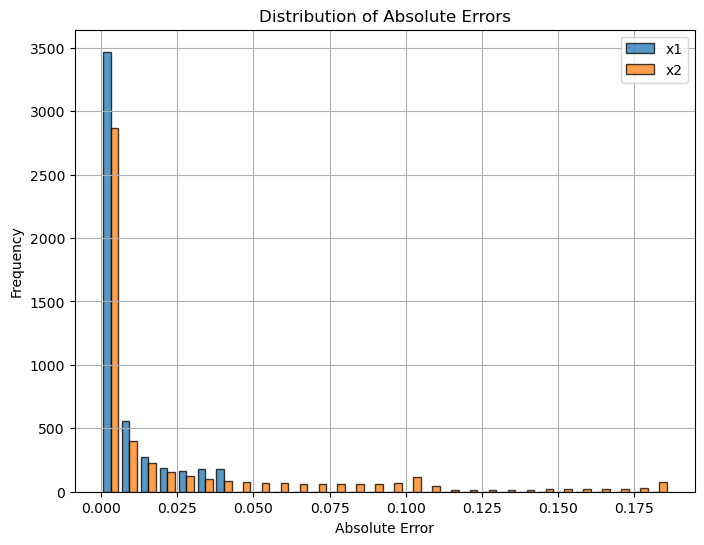

In [ ]:
u_pred_test, _, _ = model(t_test)
u_true_test = u_tests[-1]
absolute_error = tf.abs(u_pred_test - u_true_test).numpy()

plt.figure(figsize=(8, 6))
plt.hist(absolute_error, bins=30, alpha=0.75, label=["x1", "x2"], edgecolor='black')
plt.xlabel("Absolute Error")
plt.ylabel("Frequency")
plt.title("Distribution of Absolute Errors")
plt.legend()
plt.grid(True)
plt.savefig("distribution_absolute_errors_vanilla_pinn.eps", format='eps')
plt.show()


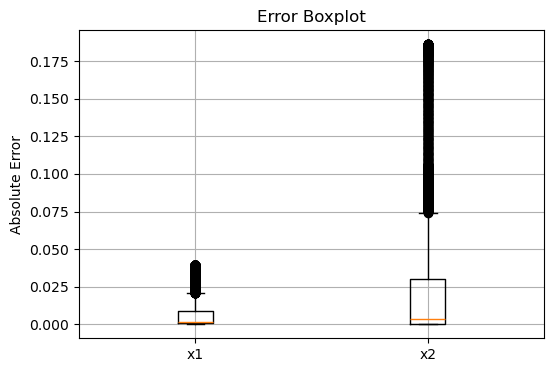

In [ ]:
plt.figure(figsize=(6, 4))
plt.boxplot(absolute_error, tick_labels=["x1", "x2"], vert=True)
plt.ylabel('Absolute Error')
plt.title('Error Boxplot')
plt.grid(True)
plt.savefig('error_boxplot_curriculum_stacked_pinn.eps', format='eps')
plt.show()


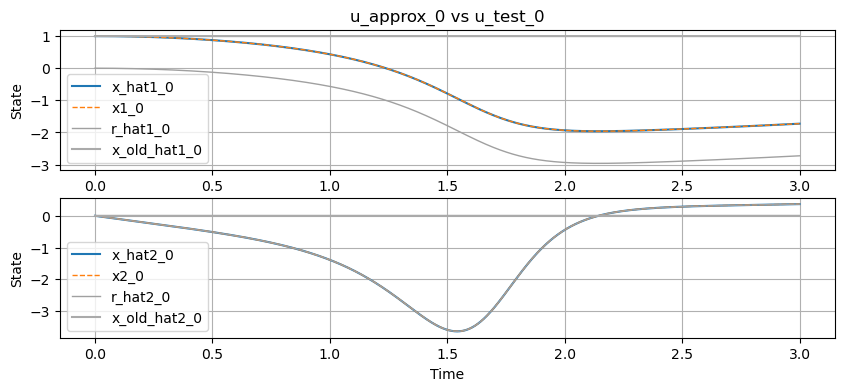

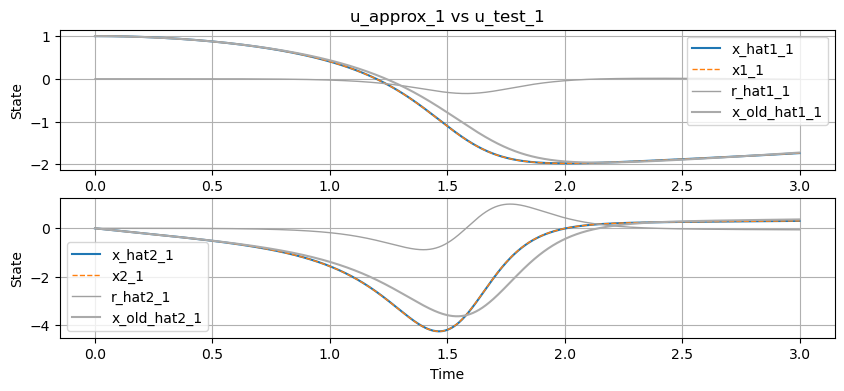

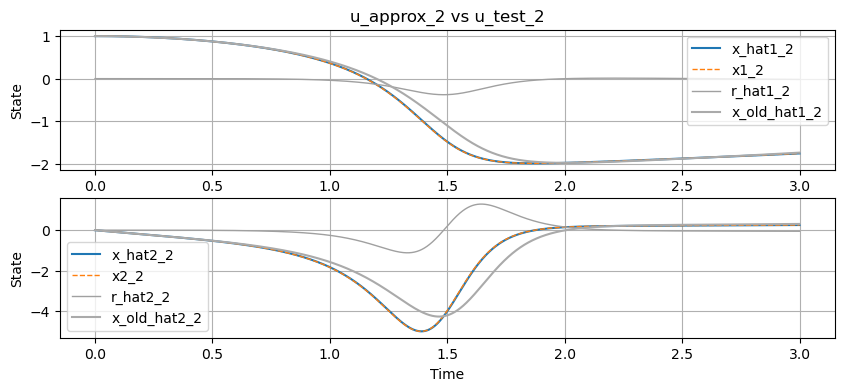

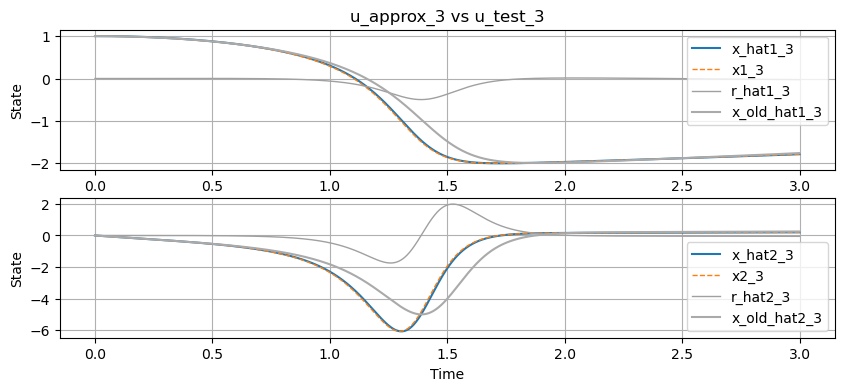

In [ ]:
"""
Plot the comparison of the output of each stack with the solution it tries to approximate
"""
# get the analytical solution each stack tries to approximate
n_steps = int(5e3)
u_tests = []
for i in range(n_stacked_mf_layers+1):
    u_test, t_test = analytical_solution(n_steps, mu=pinn.gammas[i]*real_mu, T_max=T_max, u_0=u_0)
    u_tests.append(u_test)
t_test = tf.reshape(t_test, (-1, 1))

u_approx = []
r_approx = []
u_old_approx = []
u_true = []
t_test_np =tf.reshape(t_test, [-1]).numpy()
sorted_indices = np.argsort(t_test_np)
t_sorted = t_test_np[sorted_indices]

# get the output of each stack and plot it
for i in range(n_stacked_mf_layers+1):
    u_i, u_old, r_i  = model(t_test, i=i)
    
    u_i_np = u_i.numpy()
    u_i_sorted = u_i_np[sorted_indices]
    u_approx.append(u_i_sorted)
    
    r_i_np = r_i.numpy()
    r_i_sorted = r_i_np[sorted_indices]
    r_approx.append(r_i_sorted)

    u_old_np = u_old.numpy()
    u_old_sorted = u_old_np[sorted_indices]
    u_old_approx.append(u_old_sorted)

    u_true_i_np = u_tests[i].numpy()
    u_true_i_sorted = u_true_i_np[sorted_indices]
    u_true.append(u_true_i_sorted)

    plt.figure(figsize=(10, 4))

    plt.subplot(2, 1, 1)
    plt.plot(t_sorted, u_i_sorted[:, 0], label=f'x_hat1_{i}')
    plt.plot(t_sorted, u_true_i_sorted[:, 0], linestyle='--', linewidth=1, label=f'x1_{i}')
    plt.plot(t_sorted, r_i_sorted[:, 0], linewidth=1, label=f'r_hat1_{i}', color='#A0A0A0')
    plt.plot(t_sorted, u_old_sorted[:, 0], linewidth=1.5, label=f'x_old_hat1_{i}', color='#AAAAAA')
    plt.xlabel("Time")
    plt.ylabel("State")
    plt.title(f"u_approx_{i} vs u_test_{i}")
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 1, 2)
    plt.plot(t_sorted, u_i_sorted[:, 1], label=f'x_hat2_{i}')
    plt.plot(t_sorted, u_true_i_sorted[:, 1], linestyle='--', linewidth=1, label=f'x2_{i}')
    plt.plot(t_sorted, r_i_sorted[:, 1], linewidth=1, label=f'r_hat2_{i}', color='#A0A0A0')
    plt.plot(t_sorted, u_old_sorted[:, 1], linewidth=1.5, label=f'x_old_hat2_{i}', color='#AAAAAA')
    plt.xlabel("Time")
    plt.ylabel("State")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"u_approx_{i} vs u_test_{i}.eps", format='eps')
    plt.show()